# Implementing an LSTM RNN Model
------------------------
Here we implement an LSTM model on all a data set of Shakespeare works.

We start by loading the necessary libraries and resetting the default computational graph.

In [1]:
import os
import re
import string
import requests
import numpy as np
import collections
import random
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
ops.reset_default_graph()

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


We start a computational graph session.

In [2]:
sess = tf.Session()

Next, it is important to set the algorithm and data processing parameters.

---------
Parameter  :  Descriptions
 - min_word_freq: Only attempt to model words that appear at least 5 times.
 - rnn_size: size of our RNN (equal to the embedding size)
 - epochs: Number of epochs to cycle through the data
 - batch_size: How many examples to train on at once
 - learning_rate: The learning rate or the convergence paramter
 - training_seq_len: The length of the surrounding word group (e.g. 10 = 5 on each side)
 - embedding_size: Must be equal to the rnn_size
 - save_every: How often to save the model
 - eval_every: How often to evaluate the model
 - prime_texts: List of test sentences

In [3]:
# Set RNN Parameters
min_word_freq = 5 # Trim the less frequent words off
rnn_size = 128 # RNN Model size
embedding_size = 100 # Word embedding size
epochs = 10 # Number of epochs to cycle through data
batch_size = 100 # Train on this many examples at once
learning_rate = 0.001 # Learning rate
training_seq_len = 50 # how long of a word group to consider 
embedding_size = rnn_size
save_every = 500 # How often to save model checkpoints
eval_every = 50 # How often to evaluate the test sentences
prime_texts = ['thou art more', 'to be or not to', 'wherefore art thou']

# Download/store Shakespeare data
data_dir = 'temp'
data_file = 'shakespeare.txt'
model_path = 'shakespeare_model'
full_model_dir = os.path.join(data_dir, model_path)

# Declare punctuation to remove, everything except hyphens and apostrophes
punctuation = string.punctuation
punctuation = ''.join([x for x in punctuation if x not in ['-', "'"]])

# Make Model Directory
if not os.path.exists(full_model_dir):
    os.makedirs(full_model_dir)

# Make data directory
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

Download the data if we don't have it saved already.  The data comes from the [Gutenberg Project](http://www.gutenberg.org])

In [4]:
print('Loading Shakespeare Data')
# Check if file is downloaded.
if not os.path.isfile(os.path.join(data_dir, data_file)):
    print('Not found, downloading Shakespeare texts from www.gutenberg.org')
    shakespeare_url = 'http://www.gutenberg.org/cache/epub/100/pg100.txt'
    # Get Shakespeare text
    response = requests.get(shakespeare_url)
    shakespeare_file = response.content
    # Decode binary into string
    s_text = shakespeare_file.decode('utf-8')
    # Drop first few descriptive paragraphs.
    s_text = s_text[7675:]
    # Remove newlines
    s_text = s_text.replace('\r\n', '')
    s_text = s_text.replace('\n', '')
    
    # Write to file
    with open(os.path.join(data_dir, data_file), 'w') as out_conn:
        out_conn.write(s_text)
else:
    # If file has been saved, load from that file
    with open(os.path.join(data_dir, data_file), 'r') as file_conn:
        s_text = file_conn.read().replace('\n', '')

# Clean text
print('Cleaning Text')
s_text = re.sub(r'[{}]'.format(punctuation), ' ', s_text)
s_text = re.sub('\s+', ' ', s_text ).strip().lower()
print('Done loading/cleaning.')

Loading Shakespeare Data
Not found, downloading Shakespeare texts from www.gutenberg.org
Cleaning Text
Done loading/cleaning.


Define a function to build a word processing dictionary (word -> ix)

In [5]:
# Build word vocabulary function
def build_vocab(text, min_word_freq):
    word_counts = collections.Counter(text.split(' '))
    # limit word counts to those more frequent than cutoff
    word_counts = {key:val for key, val in word_counts.items() if val>min_word_freq}
    # Create vocab --> index mapping
    words = word_counts.keys()
    vocab_to_ix_dict = {key:(ix+1) for ix, key in enumerate(words)}
    # Add unknown key --> 0 index
    vocab_to_ix_dict['unknown']=0
    # Create index --> vocab mapping
    ix_to_vocab_dict = {val:key for key,val in vocab_to_ix_dict.items()}
    
    return(ix_to_vocab_dict, vocab_to_ix_dict)

Now we can build the index-vocabulary from the Shakespeare data.

In [6]:
# Build Shakespeare vocabulary
print('Building Shakespeare Vocab')
ix2vocab, vocab2ix = build_vocab(s_text, min_word_freq)
vocab_size = len(ix2vocab) + 1
print('Vocabulary Length = {}'.format(vocab_size))
# Sanity Check
assert(len(ix2vocab) == len(vocab2ix))

# Convert text to word vectors
s_text_words = s_text.split(' ')
s_text_ix = []
for ix, x in enumerate(s_text_words):
    try:
        s_text_ix.append(vocab2ix[x])
    except:
        s_text_ix.append(0)
s_text_ix = np.array(s_text_ix)

Building Shakespeare Vocab
Vocabulary Length = 8009


We define the LSTM model.  The methods of interest are the `__init__()` method, which defines all the model variables and operations, and the `sample()` method which takes in a sample word and loops through to generate text.

In [7]:
# Define LSTM RNN Model
class LSTM_Model():
    def __init__(self, embedding_size, rnn_size, batch_size, learning_rate,
                 training_seq_len, vocab_size, infer_sample=False):
        self.embedding_size = embedding_size
        self.rnn_size = rnn_size
        self.vocab_size = vocab_size
        self.infer_sample = infer_sample
        self.learning_rate = learning_rate
        
        if infer_sample:
            self.batch_size = 1
            self.training_seq_len = 1
        else:
            self.batch_size = batch_size
            self.training_seq_len = training_seq_len
        
        self.lstm_cell = tf.contrib.rnn.BasicLSTMCell(self.rnn_size)
        self.initial_state = self.lstm_cell.zero_state(self.batch_size, tf.float32)
        
        self.x_data = tf.placeholder(tf.int32, [self.batch_size, self.training_seq_len])
        self.y_output = tf.placeholder(tf.int32, [self.batch_size, self.training_seq_len])
        
        with tf.variable_scope('lstm_vars'):
            # Softmax Output Weights
            W = tf.get_variable('W', [self.rnn_size, self.vocab_size], tf.float32, tf.random_normal_initializer())
            b = tf.get_variable('b', [self.vocab_size], tf.float32, tf.constant_initializer(0.0))
        
            # Define Embedding
            embedding_mat = tf.get_variable('embedding_mat', [self.vocab_size, self.embedding_size],
                                            tf.float32, tf.random_normal_initializer())
                                            
            embedding_output = tf.nn.embedding_lookup(embedding_mat, self.x_data)
            rnn_inputs = tf.split(axis=1, num_or_size_splits=self.training_seq_len, value=embedding_output)
            rnn_inputs_trimmed = [tf.squeeze(x, [1]) for x in rnn_inputs]
        
        # If we are inferring (generating text), we add a 'loop' function
        # Define how to get the i+1 th input from the i th output
        def inferred_loop(prev, count):
            # Apply hidden layer
            prev_transformed = tf.matmul(prev, W) + b
            # Get the index of the output (also don't run the gradient)
            prev_symbol = tf.stop_gradient(tf.argmax(prev_transformed, 1))
            # Get embedded vector
            output = tf.nn.embedding_lookup(embedding_mat, prev_symbol)
            return(output)
        
        decoder = tf.contrib.legacy_seq2seq.rnn_decoder
        outputs, last_state = decoder(rnn_inputs_trimmed,
                                      self.initial_state,
                                      self.lstm_cell,
                                      loop_function=inferred_loop if infer_sample else None)
        # Non inferred outputs
        output = tf.reshape(tf.concat(axis=1, values=outputs), [-1, self.rnn_size])
        # Logits and output
        self.logit_output = tf.matmul(output, W) + b
        self.model_output = tf.nn.softmax(self.logit_output)
        
        loss_fun = tf.contrib.legacy_seq2seq.sequence_loss_by_example
        loss = loss_fun([self.logit_output],[tf.reshape(self.y_output, [-1])],
                [tf.ones([self.batch_size * self.training_seq_len])],
                self.vocab_size)
        self.cost = tf.reduce_sum(loss) / (self.batch_size * self.training_seq_len)
        self.final_state = last_state
        gradients, _ = tf.clip_by_global_norm(tf.gradients(self.cost, tf.trainable_variables()), 4.5)
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.train_op = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))
        
    def sample(self, sess, words=ix2vocab, vocab=vocab2ix, num=10, prime_text='thou art'):
        state = sess.run(self.lstm_cell.zero_state(1, tf.float32))
        word_list = prime_text.split()
        for word in word_list[:-1]:
            x = np.zeros((1, 1))
            x[0, 0] = vocab[word]
            feed_dict = {self.x_data: x, self.initial_state:state}
            [state] = sess.run([self.final_state], feed_dict=feed_dict)

        out_sentence = prime_text
        word = word_list[-1]
        for n in range(num):
            x = np.zeros((1, 1))
            x[0, 0] = vocab[word]
            feed_dict = {self.x_data: x, self.initial_state:state}
            [model_output, state] = sess.run([self.model_output, self.final_state], feed_dict=feed_dict)
            sample = np.argmax(model_output[0])
            if sample == 0:
                break
            word = words[sample]
            out_sentence = out_sentence + ' ' + word
        return(out_sentence)

In order to use the same model (with the same trained variables), we need to share the variable scope between the trained model and the test model.

In [8]:
# Define LSTM Model
lstm_model = LSTM_Model(embedding_size, rnn_size, batch_size, learning_rate,
                        training_seq_len, vocab_size)

# Tell TensorFlow we are reusing the scope for the testing
with tf.variable_scope(tf.get_variable_scope(), reuse=True):
    test_lstm_model = LSTM_Model(embedding_size, rnn_size, batch_size, learning_rate,
                                 training_seq_len, vocab_size, infer_sample=True)

We need to save the model, so we create a model saving operation.

In [9]:
# Create model saver
saver = tf.train.Saver(tf.global_variables())

Let's calculate how many batches are needed for each epoch and split up the data accordingly.

In [10]:
# Create batches for each epoch
num_batches = int(len(s_text_ix)/(batch_size * training_seq_len)) + 1
# Split up text indices into subarrays, of equal size
batches = np.array_split(s_text_ix, num_batches)
# Reshape each split into [batch_size, training_seq_len]
batches = [np.resize(x, [batch_size, training_seq_len]) for x in batches]

Initialize all the variables

In [11]:
# Initialize all variables
init = tf.global_variables_initializer()
sess.run(init)

Training the model!

In [12]:
# Train model
train_loss = []
iteration_count = 1
for epoch in range(epochs):
    # Shuffle word indices
    random.shuffle(batches)
    # Create targets from shuffled batches
    targets = [np.roll(x, -1, axis=1) for x in batches]
    # Run a through one epoch
    print('Starting Epoch #{} of {}.'.format(epoch+1, epochs))
    # Reset initial LSTM state every epoch
    state = sess.run(lstm_model.initial_state)
    for ix, batch in enumerate(batches):
        training_dict = {lstm_model.x_data: batch, lstm_model.y_output: targets[ix]}
        c, h = lstm_model.initial_state
        training_dict[c] = state.c
        training_dict[h] = state.h
        
        temp_loss, state, _ = sess.run([lstm_model.cost, lstm_model.final_state, lstm_model.train_op],
                                       feed_dict=training_dict)
        train_loss.append(temp_loss)
        
        # Print status every 10 gens
        if iteration_count % 10 == 0:
            summary_nums = (iteration_count, epoch+1, ix+1, num_batches+1, temp_loss)
            print('Iteration: {}, Epoch: {}, Batch: {} out of {}, Loss: {:.2f}'.format(*summary_nums))
        
        # Save the model and the vocab
        if iteration_count % save_every == 0:
            # Save model
            model_file_name = os.path.join(full_model_dir, 'model')
            saver.save(sess, model_file_name, global_step = iteration_count)
            print('Model Saved To: {}'.format(model_file_name))
            # Save vocabulary
            dictionary_file = os.path.join(full_model_dir, 'vocab.pkl')
            with open(dictionary_file, 'wb') as dict_file_conn:
                pickle.dump([vocab2ix, ix2vocab], dict_file_conn)
        
        if iteration_count % eval_every == 0:
            for sample in prime_texts:
                print(test_lstm_model.sample(sess, ix2vocab, vocab2ix, num=10, prime_text=sample))
                
        iteration_count += 1

Starting Epoch #1 of 10.
Iteration: 10, Epoch: 1, Batch: 10 out of 182, Loss: 9.89
Iteration: 20, Epoch: 1, Batch: 20 out of 182, Loss: 8.97
Iteration: 30, Epoch: 1, Batch: 30 out of 182, Loss: 8.57
Iteration: 40, Epoch: 1, Batch: 40 out of 182, Loss: 8.33
Iteration: 50, Epoch: 1, Batch: 50 out of 182, Loss: 7.97
thou art more syracusian i have
to be or not to the
wherefore art thou hither '- arise
Iteration: 60, Epoch: 1, Batch: 60 out of 182, Loss: 7.63
Iteration: 70, Epoch: 1, Batch: 70 out of 182, Loss: 7.63
Iteration: 80, Epoch: 1, Batch: 80 out of 182, Loss: 7.50
Iteration: 90, Epoch: 1, Batch: 90 out of 182, Loss: 7.13
Iteration: 100, Epoch: 1, Batch: 100 out of 182, Loss: 7.13
thou art more in the
to be or not to the
wherefore art thou not be
Iteration: 110, Epoch: 1, Batch: 110 out of 182, Loss: 7.01
Iteration: 120, Epoch: 1, Batch: 120 out of 182, Loss: 6.91
Iteration: 130, Epoch: 1, Batch: 130 out of 182, Loss: 6.96
Iteration: 140, Epoch: 1, Batch: 140 out of 182, Loss: 6.58

Iteration: 1030, Epoch: 6, Batch: 125 out of 182, Loss: 5.91
Iteration: 1040, Epoch: 6, Batch: 135 out of 182, Loss: 5.93
Iteration: 1050, Epoch: 6, Batch: 145 out of 182, Loss: 6.01
thou art more than the
to be or not to the
wherefore art thou hast thou hast thou hast thou hast thou hast thou
Iteration: 1060, Epoch: 6, Batch: 155 out of 182, Loss: 5.93
Iteration: 1070, Epoch: 6, Batch: 165 out of 182, Loss: 5.90
Iteration: 1080, Epoch: 6, Batch: 175 out of 182, Loss: 5.87
Starting Epoch #7 of 10.
Iteration: 1090, Epoch: 7, Batch: 4 out of 182, Loss: 5.89
Iteration: 1100, Epoch: 7, Batch: 14 out of 182, Loss: 5.82
thou art more than the
to be or not to the
wherefore art thou hast thou hast thou hast thou hast thou hast thou
Iteration: 1110, Epoch: 7, Batch: 24 out of 182, Loss: 5.85
Iteration: 1120, Epoch: 7, Batch: 34 out of 182, Loss: 5.85
Iteration: 1130, Epoch: 7, Batch: 44 out of 182, Loss: 5.93
Iteration: 1140, Epoch: 7, Batch: 54 out of 182, Loss: 5.86
Iteration: 1150, Epoch: 7,

Here is a plot of the training loss across the iterations.

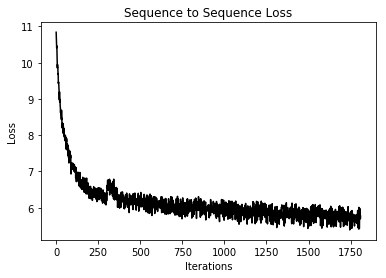

In [13]:
# Plot loss over time
plt.plot(train_loss, 'k-')
plt.title('Sequence to Sequence Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [ ]:
test complete; Gopal